In [1]:
import os
from pathlib import Path

import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets

from tqdm import tqdm

import time

from PIL import Image
import matplotlib.pyplot as plt

#used for finding most emoji-like final generated image
import torch.nn.functional as F_nn

colab = os.getenv('COLAB_GPU') != None

if colab:
    #used for making folders from Google Drive accessible
    from google.colab import drive

Ran for GPU compatability for running the model on local system:


---


**(Don't run these commands for running on Google Colab)**

> pip uninstall torch torchvision torchaudio

> pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
#doesn't need to run on Google Colab, just checks if running the model locally that it will use your GPU


#makes sure GPU will be used for processing
if not colab:
    print("CUDA version for PyTorch", torch.version.cuda)
    print(torch.cuda.get_device_name(0))
    processing_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.set_default_device(processing_device)
    print(f"Model will use: {torch.get_default_device()}")


CUDA version for PyTorch 11.8
NVIDIA GeForce RTX 3060 Laptop GPU
Model will use: cuda:0


In [3]:
#directory path from Colab Notebooks folder in Google Drive
folder = "images_faces_only"

image_folder_path = folder
if colab:
    drive.mount("/content/drive")
    image_folder_path = f"/content/drive/My Drive/Colab Notebooks/{folder}"

print(f"\nVerifying that the images can be found in the directory and used in the model in the folder \"{folder}\":")
print(os.listdir(image_folder_path))



Verifying that the images can be found in the directory and used in the model in the folder "images_faces_only":
['JoyPixels', 'DoCoMo', 'Samsung', 'KDDI', 'Twitter', 'Apple', 'Windows', 'Facebook', 'Google', 'Gmail', 'SoftBank']


In [4]:
image_dimentions = 64

def load_and_preprocess_images(data_dir, target_size=(64, 64)):
    #got rid of dataset extra augmentation to reduce rotated corners in outputted images
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
    ])

    images = []
    labels = []
    class_to_idx = {}

    for idx, class_name in enumerate(sorted(os.listdir(data_dir))):
        class_path = os.path.join(data_dir, class_name)
        
        # Only train on certain classes
        if class_name not in ['Apple', 'Google', 'Facebook', 'Samsung', 'Twitter', 'Windows', 'JoyPixels']:
            continue
        
        class_to_idx[class_name] = idx
        for file_name in tqdm(os.listdir(class_path)):
            file_path = os.path.join(class_path, file_name)
            if os.path.isdir(file_path):
                continue
            image = Image.open(file_path).convert("RGB")
            image = transform(image)
            images.append(image)
            labels.append(idx)

    images = torch.stack(images)
    labels = torch.tensor(labels)

    #if running on cuda:
    #images = torch.stack(images).to(processing_device)
    #labels = torch.tensor(labels).to(processing_device)

    return images, labels, class_to_idx

#loading the data
data_dir = image_folder_path #directory path from Colab Notebooks folder in Google Drive
target_size = (image_dimentions, image_dimentions)
images, labels, class_to_idx = load_and_preprocess_images(data_dir, target_size)

/home/sockyman/src/venv/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(







00%|███████████████████████████████████████████████████████████| 322/322 [00:00<00:00, 2187.29it/s]

In [68]:
class GeneratorNet(nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0),  #layer takes in (100, 1, 1), and outputs (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  #layer outputs (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  #layer outputs (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   #layer outputs (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),     #returns an image of dimensions (3, 64, 64)
            nn.Tanh(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 100, 1, 1)  #reshape noise to input layer dimensions for the batch_size with (100, 1, 1)
        return self.model(x)

generator = GeneratorNet()

#if running on cuda:
#generator = GeneratorNet().to(processing_device)

In [69]:
class DiscriminatorNet(nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),      #layer takes in image (3, 64, 64), and outputs (64, 32, 32)
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),    #layer outputs (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),   #layer outputs (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),   #layer outputs (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, 1, 0),     #layer outputs (1, 1, 1)
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)

discriminator = DiscriminatorNet()

#if running locally use instead:
#discriminator = DiscriminatorNet().to(processing_device)

In [70]:
import torchinfo
print(torchinfo.summary(generator, input_size=(128, 100, 1, 1)))
print(torchinfo.summary(discriminator, input_size=(128, 3, 64, 64)))

Layer (type:depth-idx)                   Output Shape              Param #
GeneratorNet                             [128, 3, 64, 64]          --
├─Sequential: 1-1                        [128, 3, 64, 64]          --
│    └─ConvTranspose2d: 2-1              [128, 512, 4, 4]          819,712
│    └─BatchNorm2d: 2-2                  [128, 512, 4, 4]          1,024
│    └─ReLU: 2-3                         [128, 512, 4, 4]          --
│    └─ConvTranspose2d: 2-4              [128, 256, 8, 8]          2,097,408
│    └─BatchNorm2d: 2-5                  [128, 256, 8, 8]          512
│    └─ReLU: 2-6                         [128, 256, 8, 8]          --
│    └─ConvTranspose2d: 2-7              [128, 128, 16, 16]        524,416
│    └─BatchNorm2d: 2-8                  [128, 128, 16, 16]        256
│    └─ReLU: 2-9                         [128, 128, 16, 16]        --
│    └─ConvTranspose2d: 2-10             [128, 64, 32, 32]         131,136
│    └─BatchNorm2d: 2-11                 [128, 64, 32, 32]

In [71]:
#if on cuda add param to all return statements: (..., device=processing_device)

def real_targets(size):
    return torch.full((size, 1), 0.9) #added label smoothing (floating points)

def fake_targets(size):
    return torch.full((size, 1), 0.1) #added label smoothing (floating points)

def noise(size):
    return torch.randn(size, 100)  #assume noise vector has 100 features

In [72]:
def image_grid(width, height, show_image=True, save_path=None, input_noise=None, size=8):
    if input_noise == None:
        input_noise = noise(width * height)
    generated_images = generator(input_noise).detach()
    grid = torchvision.utils.make_grid(generated_images, nrow=width, normalize=True)
    plt.figure(figsize=(size, size))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")

    if save_path != None:
        path = Path(save_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(path)
    
    if show_image:
        plt.show()

Epoch #0 / 2000, Generator Loss: 2.3680030381001416e-08, Discriminator Loss: -0.9999996423721313
Generated images for Epoch #0:


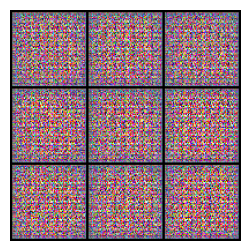

0:02
Epoch #1 / 2000, Generator Loss: 1.0969374741875981e-08, Discriminator Loss: -0.9999996423721313
Epoch #2 / 2000, Generator Loss: 8.527726080842513e-09, Discriminator Loss: -0.9999996423721313
Epoch #3 / 2000, Generator Loss: 7.631163256860418e-09, Discriminator Loss: -0.9999996423721313
Epoch #4 / 2000, Generator Loss: 6.8377796758056775e-09, Discriminator Loss: -0.9999996423721313
Generated images for Epoch #4:


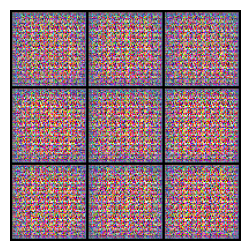

0:13
Epoch #5 / 2000, Generator Loss: 6.2114620114073205e-09, Discriminator Loss: -0.9999996423721313
Epoch #6 / 2000, Generator Loss: 5.766881194801954e-09, Discriminator Loss: -0.9999996423721313
Epoch #7 / 2000, Generator Loss: 5.479229958638143e-09, Discriminator Loss: -0.9999996423721313
Epoch #8 / 2000, Generator Loss: 5.156336690959051e-09, Discriminator Loss: -0.9999996423721313
Generated images for Epoch #8:


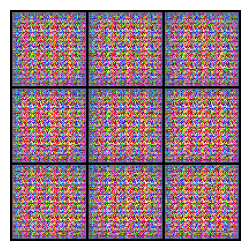

0:23
Epoch #9 / 2000, Generator Loss: 4.792532593000942e-09, Discriminator Loss: -0.9999996423721313
Epoch #10 / 2000, Generator Loss: 4.538500242290411e-09, Discriminator Loss: -0.9999996423721313
Epoch #11 / 2000, Generator Loss: 4.321901947434981e-09, Discriminator Loss: -0.9999996423721313
Epoch #12 / 2000, Generator Loss: 4.196171854431441e-09, Discriminator Loss: -0.9999996423721313
Generated images for Epoch #12:


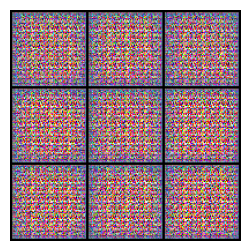

0:34
Epoch #13 / 2000, Generator Loss: 3.9293710507593005e-09, Discriminator Loss: -0.9999996423721313
Epoch #14 / 2000, Generator Loss: 3.92205601329465e-09, Discriminator Loss: -0.9999996423721313
Epoch #15 / 2000, Generator Loss: 3.605819198782001e-09, Discriminator Loss: -0.9999996423721313
Epoch #16 / 2000, Generator Loss: 3.4948741678419992e-09, Discriminator Loss: -0.9999996423721313
Generated images for Epoch #16:


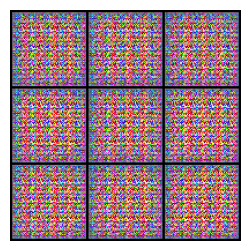

0:45
Epoch #17 / 2000, Generator Loss: 3.340080434455217e-09, Discriminator Loss: -0.9999996423721313


KeyboardInterrupt: 

In [73]:
#use binary cross entropy for loss
loss_function = nn.BCELoss()

num_epochs = 200
#for best results use: num_epochs = 800
num_epochs = 2000

batch_size = 256
d_losses, g_losses = [], []

#define dataloaders
dataset = TensorDataset(images, labels)

# We need a random number generator that works on gpu for shuffle to work
random_generator = torch.Generator(device=torch.get_default_device())
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=random_generator)

#learning rate and optimizers
learning_rate = 0.0002
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)

start_time = time.time()

sample_noise = noise(9)

image_epoch_frequency = 4
# How many times to train the discriminator for 1 pass on the generator
discriminator_passes = 3

#training loop for generating emojis
for epoch in range(num_epochs):
    #dataloader shuffles the batches

    for d_pass in range(discriminator_passes):
        for real_data, iteration in dataloader:
            #only need this line if running on cuda:
            real_data = real_data.to(processing_device)
    
            #train the discriminator
            d_optimizer.zero_grad()
            real_pred = discriminator(real_data)
            #real_loss = loss_function(real_pred, real_targets(real_data.size(0)))
            real_loss = torch.mean(real_pred)
            real_loss.backward()
            
            fake_data = generator(noise(real_data.size(0))).detach()
            fake_pred = discriminator(fake_data)
            #fake_loss = loss_function(fake_pred, fake_targets(fake_data.size(0)))
            fake_loss = torch.mean(fake_pred)
            fake_loss.backward()
            #d_loss = real_loss + fake_loss
            #d_loss = fake_loss - real_loss
            #d_loss.backward()
            d_optimizer.step()

    for real_data, iteration in dataloader:
        #train the generator
        g_optimizer.zero_grad()
        fake_data = generator(noise(batch_size))
        fake_pred = discriminator(fake_data)
        #g_loss = loss_function(fake_pred, real_targets(batch_size))
        g_loss = torch.mean(fake_pred)
        g_loss.backward()
        g_optimizer.step()

    #record losses
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    print(f"Epoch #{epoch} / {num_epochs}, Generator Loss: {g_loss.item()}, Discriminator Loss: {d_loss.item()}")


    #print images at every 10 epochs
    if epoch % image_epoch_frequency == 0:
        print(f"Generated images for Epoch #{epoch}:")
        image_grid(3, 3, input_noise=sample_noise, size=3, save_path=f'progress/{epoch}.jpg')

        now = int(time.time() - start_time)
        print(f'{now // 60}:{now % 60:02}')

#generate final set of images
image_grid(4, 4)

In [17]:
def best_emoji_output(generator, discriminator, generated_images):
    #if cuda is used, then the images must be on the same device (GPU using cuda)
    #generated_images = generated_images.to(processing_device)

    #target yellow color using RGB
    #if using cude make sure to use param for device: target_yellow = torch.tensor([1.0, 1.0, 0.0], device=processing_device).view(1, 3, 1, 1)
    target_yellow = torch.tensor([1.0, 1.0, 0.0]).view(1, 3, 1, 1)  #looks for a brighter yellow

    #selecting the best yellow emoji
    def select_best_yellow_emoji(generated_images, discriminator):
        scores = []
        for img in generated_images:
            #only needed for cuda usage:
            #img = img.to(processing_device)

            #gets discriminator scores
            disc_score = discriminator(img.unsqueeze(0)).item()

            #computes the color similarity to yellow
            avg_color = img.mean(dim=(1, 2))  #average color per channel
            yellow_bias = -F_nn.mse_loss(avg_color, target_yellow.view(-1))  #the lower the MSE the closer the color is to yellow

            combined_score = disc_score + yellow_bias.item()
            scores.append(combined_score)

        #gets the image with highest score
        best_index = scores.index(max(scores))
        best_image = generated_images[best_index]
        print(f"The best generated emoji had a score of: {scores[best_index]}")
        return best_image

    best_emoji = select_best_yellow_emoji(generated_images, discriminator)

    #output the best emoji
    print(f"Here is the best chosen, final generated emoji:")
    plt.figure(figsize=(4, 4))
    grid = torchvision.utils.make_grid(best_emoji.unsqueeze(0), normalize=True)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.show()

best_emoji_output(generator, discriminator, generated_images)

NameError: name 'generator' is not defined

In [1]:
image_grid(4, 4)

NameError: name 'image_grid' is not defined